# Отток клиентов

## Описание проекта
Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.


## 1. Изучение общей информации:



In [37]:
import pandas as pd
from  sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score, roc_curve, roc_auc_score 
from sklearn.utils import shuffle
import matplotlib.pyplot as plt



Загрузим данные:

In [38]:
try:
    churn = pd.read_csv("C:\\Users\\User\\Documents\\Обучение_с_учителем\\churn.csv")
    churn.to_csv("churn.csv")
except:
    churn = pd.read_csv("/datasets/Churn.csv")

display(churn.sample(10))

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6171,6171,6171,6171,6172,15673837,Ko,617,Spain,Male,61,3.0,113858.95,1,1,1,38129.22,0
8550,8550,8550,8550,8551,15709016,North,687,Germany,Female,47,1.0,91219.29,1,0,0,158845.49,1
6341,6341,6341,6341,6342,15658364,Laney,807,Germany,Female,40,1.0,134590.21,1,1,1,46253.65,0
1879,1879,1879,1879,1880,15768095,Yeh,579,France,Male,31,9.0,0.00,1,0,1,139048.00,0
9817,9817,9817,9817,9818,15812611,Lorimer,690,Spain,Female,30,5.0,0.00,2,0,1,78700.03,0
9643,9643,9643,9643,9644,15709354,Tudawali,521,France,Female,41,2.0,0.00,2,1,1,113089.43,0
3309,3309,3309,3309,3310,15753343,Barry,523,France,Female,28,2.0,121164.11,1,1,1,59938.81,0
318,318,318,318,319,15677512,McEncroe,628,Spain,Female,22,3.0,0.00,1,1,0,85426.28,0
4217,4217,4217,4217,4218,15583840,Okechukwu,587,Germany,Male,35,5.0,121863.61,1,1,1,23481.69,1
3633,3633,3633,3633,3634,15629846,Sheehan,827,Germany,Female,47,8.0,143001.50,2,1,0,108977.50,0


Согласно документации мы имеем следующий набор данных:

Признаки:
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — сколько лет человек является клиентом банка
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

Целевой признак
* Exited — факт ухода клиента

In [39]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.2     10000 non-null  int64  
 1   Unnamed: 0.1     10000 non-null  int64  
 2   Unnamed: 0       10000 non-null  int64  
 3   RowNumber        10000 non-null  int64  
 4   CustomerId       10000 non-null  int64  
 5   Surname          10000 non-null  object 
 6   CreditScore      10000 non-null  int64  
 7   Geography        10000 non-null  object 
 8   Gender           10000 non-null  object 
 9   Age              10000 non-null  int64  
 10  Tenure           9091 non-null   float64
 11  Balance          10000 non-null  float64
 12  NumOfProducts    10000 non-null  int64  
 13  HasCrCard        10000 non-null  int64  
 14  IsActiveMember   10000 non-null  int64  
 15  EstimatedSalary  10000 non-null  float64
 16  Exited           10000 non-null  int64  
dtypes: float64(3)

In [40]:
churn.duplicated().sum()

0

### Вывод: 

Итак, в нашем датасете всего 14 признаков и 10000 объектов. Категориалные признаки преобразуем техникой OHE для работы с разными моделями обучения. 6 количественных признака необходимо привести к одному масштабу.

В столбце `Tenure` наблюдается 909 пропусков, которые мы заполним нулями. Типы данных соответствуют своим значениям. Дубликаты отсутствуют.

## 2. Предобработка данных и подготовка признаков.

Заполним пропуски в столбце `Tenure` модой:

In [41]:
churn['Tenure'].value_counts()

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [42]:
churn['Tenure'] = churn['Tenure'].fillna(1)
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.2     10000 non-null  int64  
 1   Unnamed: 0.1     10000 non-null  int64  
 2   Unnamed: 0       10000 non-null  int64  
 3   RowNumber        10000 non-null  int64  
 4   CustomerId       10000 non-null  int64  
 5   Surname          10000 non-null  object 
 6   CreditScore      10000 non-null  int64  
 7   Geography        10000 non-null  object 
 8   Gender           10000 non-null  object 
 9   Age              10000 non-null  int64  
 10  Tenure           10000 non-null  float64
 11  Balance          10000 non-null  float64
 12  NumOfProducts    10000 non-null  int64  
 13  HasCrCard        10000 non-null  int64  
 14  IsActiveMember   10000 non-null  int64  
 15  EstimatedSalary  10000 non-null  float64
 16  Exited           10000 non-null  int64  
dtypes: float64(3)

Преобразуем категориальные признаки техникой OHE. Для этого сначала удалим те признаки, которые не понадобятся при обучении моделей:

In [43]:
churn.drop(["RowNumber", "CustomerId", "Surname"], axis=1, inplace=True)

In [44]:
df = pd.get_dummies(churn, drop_first=True)
df.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,0,0,0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,1,1,1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,2,2,2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,3,3,3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,4,4,4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Разделим наши исходные данные на обучающую, валидационную и тестовую выборки:

In [45]:
features = df.drop('Exited', axis=1)
target = df['Exited']

In [46]:
features_train, features_test_valid, target_train, target_test_valid = train_test_split(features, target, 
                                                                              test_size=0.4, 
                                                                              random_state=1, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_test_valid, target_test_valid, 
                                                                              test_size=0.5, 
                                                                              random_state=1, stratify=target_test_valid)

Масштабируем количественные признаки:

In [47]:
numeric=['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[numeric]) 
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head()


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6431,6431,6431,6431,-1.134135,0.002903,-1.194943,-1.218552,1,0,1,0.154604,0,1,1
7524,7524,7524,7524,0.105387,0.097044,1.151917,1.449089,1,1,1,1.492613,0,0,0
3430,3430,3430,3430,-0.256140,-0.185380,-1.194943,1.606871,2,1,1,-0.060400,0,0,1
9088,9088,9088,9088,0.890417,-0.279522,1.151917,0.439565,1,1,1,0.182789,1,0,0
7606,7606,7606,7606,0.311974,-0.750229,-0.524412,0.813226,3,1,1,1.340512,1,0,0


0    0.7963
1    0.2037
Name: Exited, dtype: float64

<AxesSubplot:>

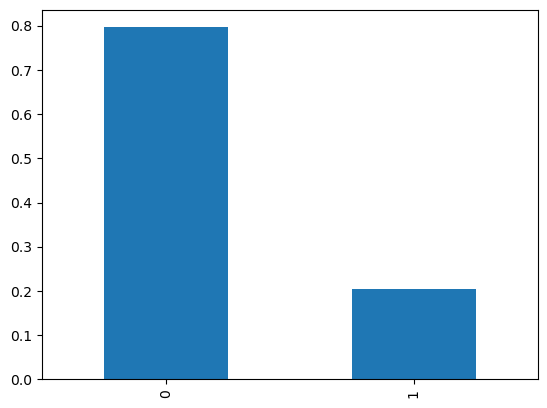

In [48]:
class_frequency = df['Exited'].value_counts(normalize=True)
display(class_frequency)
class_frequency.plot(kind='bar')


Наблюдается сильный дисбаланс классов: большая часть значений 0.

Построим модели дерева решений, случайного леса и логистической регрессии для валидационной выборки без учета дисбаланса. Найдем значение F1-меры:

best_model_rf = None  
best_result_val_rf = 0
best_depth_val_rf = 0
for depth in range(1, 20):
    rf = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth) 
    rf.fit(features_train, target_train)
    predictions_valid_rf = rf.predict(features_valid)
    result_val_rf = f1_score(target_valid, predictions_valid_rf)
    if result_val_rf > best_result_val_rf:
        best_model_rf = rf
        best_result_val_rf = result_val_rf
        best_depth_val_rf = depth
print("Наибольшее значение F1-меры для случайного леса в валидационной выборке:", best_result_val_rf, 'Глубина дерева:', best_depth_val_rf)



F1-мера равна: 0.5567651632970451


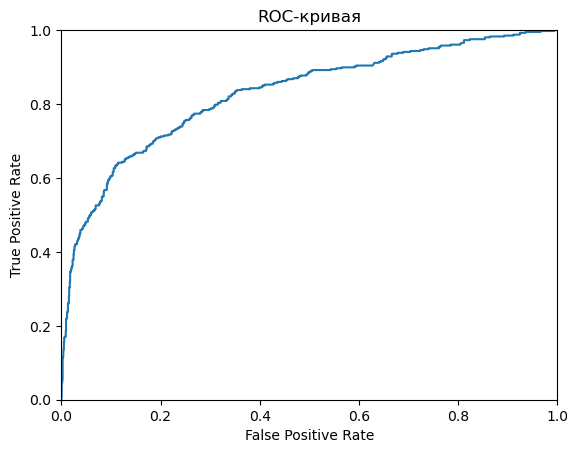

AUC-ROC равен: 0.8280576416169638


In [50]:
rf = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=15) 
rf.fit(features_train, target_train)
predictions_valid_rf = rf.predict(features_valid)
f1 = f1_score(target_valid, predictions_valid_rf)
probabilities_valid = rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print('F1-мера равна:', f1)
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) 


plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC-ROC равен:', auc_roc)

Наилучший показатель F1-меры модели случайного леса для валидационной выборки равен 0.59 при количестве деревьев, равном 30 и глубине деревьев, равном 13. AUC-ROC при этом равен 0.83. 

best_model_val_dt = None  
best_result_val_dt = 0
best_depth_val_dt = 0
for depth in range(1, 30):
    dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt.fit(features_train, target_train)
    predictions_valid_dt = dt.predict(features_valid)
    result_val_dt = f1_score(target_valid, predictions_valid_dt)
    if result_val_dt > best_result_val_dt:
        best_model_val_dt = dt
        best_result_val_dt = result_val_dt
        best_depth_val_dt = depth
print("Наибольшее значение F1-меры для решающего дерева в валидационной выборке:", best_result_val_dt, 'Глубина дерева:', best_depth_val_dt)



F1-мера равна: 0.5514018691588785


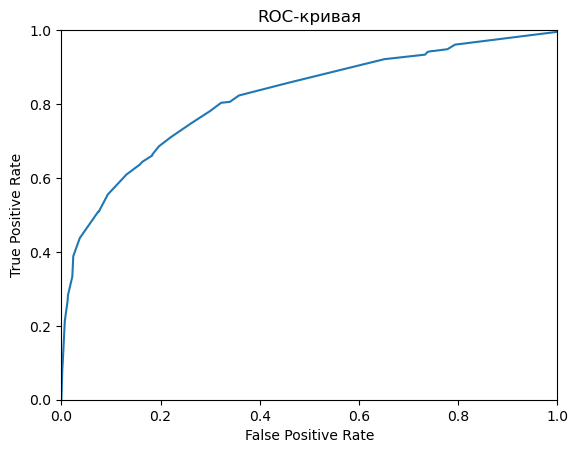

AUC-ROC равен: 0.8166417573197234


In [52]:
dt = DecisionTreeClassifier(random_state=12345, max_depth=6)
dt.fit(features_train, target_train)
predictions_valid_dt = dt.predict(features_valid)
f1_dt = f1_score(target_valid, predictions_valid_dt)
probabilities_valid_dt = dt.predict_proba(features_valid)
probabilities_one_valid_dt = probabilities_valid_dt[:, 1]
print('F1-мера равна:', f1_dt)
fpr_dt, tpr_dt, thresholds_dt = roc_curve(target_valid, probabilities_one_valid_dt) 


plt.figure()
plt.plot(fpr_dt, tpr_dt)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_dt = roc_auc_score(target_valid, probabilities_one_valid_dt)
print('AUC-ROC равен:', auc_roc_dt)

Наилучший показатель F1-меры модели дерева решений для валидационной выборки равен 0.55 при глубине деревa, равном 6. AUC-ROC при этом равен 0.82. 

F1-мера равна: 0.3274647887323943


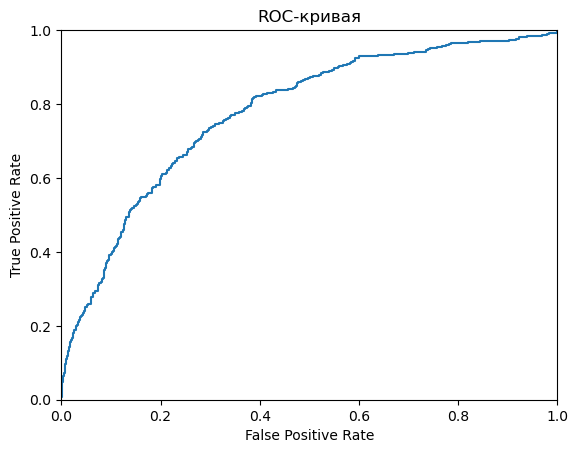

AUC-ROC равен: 0.7767258784207938


In [53]:
lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
lr.fit(features_train, target_train)
predictions_valid_lr = lr.predict(features_valid)
f1_lr = f1_score(target_valid, predictions_valid_lr)
probabilities_valid_lr = lr.predict_proba(features_valid)
probabilities_one_valid_lr = probabilities_valid_lr[:, 1]
print('F1-мера равна:', f1_lr)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(target_valid, probabilities_one_valid_lr) 


plt.figure()
plt.plot(fpr_lr, tpr_lr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_lr = roc_auc_score(target_valid, probabilities_one_valid_lr)
print('AUC-ROC равен:', auc_roc_lr)

Наилучший показатель F1-меры модели логистической регрессии для валидационной выборки равен 0.32. AUC-ROC при этом равен 0.78. 

Применим upsampling для работы с дисбалансом классов:

In [54]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)


best_model_rf1 = None  
best_result_val_rf1 = 0
best_depth_val_rf1 = 0
for depth in range(1, 20):
    rf1 = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=depth) 
    rf1.fit(features_upsampled, target_upsampled)
    predictions_valid_rf1 = rf1.predict(features_valid)
    result_val_rf1 = f1_score(target_valid, predictions_valid_rf1)
    if result_val_rf1 > best_result_val_rf1:
        best_model_rf1 = rf1
        best_result_val_rf1 = result_val_rf1
        best_depth_val_rf1 = depth
print("Наибольшее значение F1-меры для случайного леса в валидационной выборке:", best_result_val_rf1, 'Глубина дерева:', best_depth_val_rf1)



F1-мера равна: 0.5941043083900226


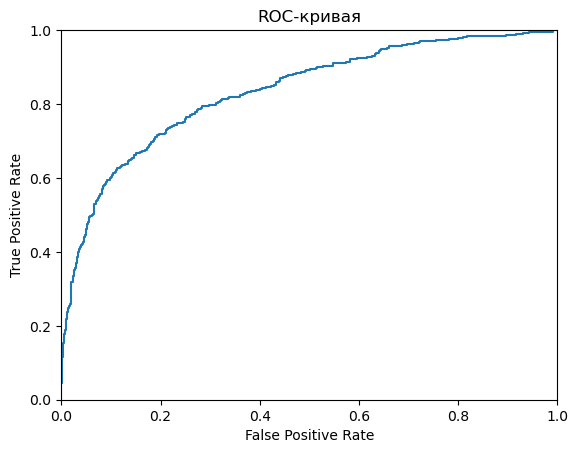

AUC-ROC равен: 0.833570087807376


In [55]:
rf1 = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=11) 
rf1.fit(features_upsampled, target_upsampled)
predictions_valid_rf1 = rf1.predict(features_valid)
f1_rf1 = f1_score(target_valid, predictions_valid_rf1)
probabilities_valid_rf1 = rf1.predict_proba(features_valid)
probabilities_one_valid_rf1 = probabilities_valid_rf1[:, 1]
print('F1-мера равна:', f1_rf1)
fpr_rf1, tpr_rf1, thresholds_rf1 = roc_curve(target_valid, probabilities_one_valid_rf1) 


plt.figure()
plt.plot(fpr_rf1, tpr_rf1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_rf1 = roc_auc_score(target_valid, probabilities_one_valid_rf1)
print('AUC-ROC равен:', auc_roc_rf1)

Наилучший показатель F1-меры модели случайного леса для валидационной выборки равен 0.6 при количестве деревьев, равном 30 и глубине деревьев, равном 11. AUC-ROC при этом равен 0.83. 

best_model_dt1 = None  
best_result_val_dt1 = 0
best_depth_val_dt1 = 0
for depth in range(1, 20):
    dt1 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt1.fit(features_upsampled, target_upsampled)
    predictions_valid_dt1 = dt1.predict(features_valid)
    result_val_dt1 = f1_score(target_valid, predictions_valid_dt1)
    if result_val_dt1 > best_result_val_dt1:
        best_model_dt1 = dt1
        best_result_val_dt1 = result_val_dt1
        best_depth_val_dt1 = depth
print("Наибольшее значение F1-меры для решающего дерева в валидационной выборке:", best_result_val_dt1, 'Глубина дерева:', best_depth_val_dt1)



F1-мера равна: 0.5597609561752988


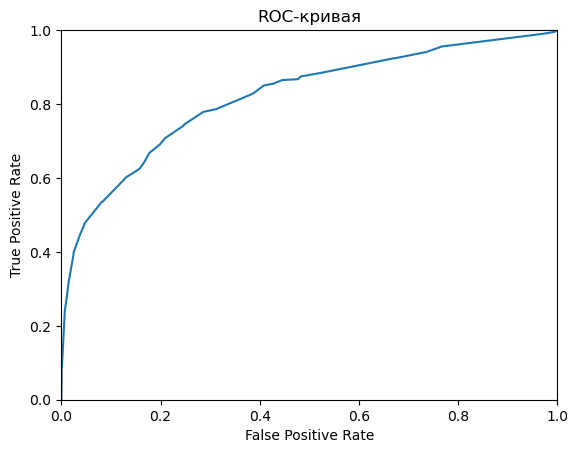

AUC-ROC равен: 0.8195745822864468


In [56]:
dt1 = DecisionTreeClassifier(random_state=12345, max_depth=6)
dt1.fit(features_upsampled, target_upsampled)
predictions_valid_dt1 = dt1.predict(features_valid)
f1_dt1 = f1_score(target_valid, predictions_valid_dt1)
probabilities_valid_dt1 = dt1.predict_proba(features_valid)
probabilities_one_valid_dt1 = probabilities_valid_dt1[:, 1]
print('F1-мера равна:', f1_dt1)
fpr_dt1, tpr_dt1, thresholds_dt1 = roc_curve(target_valid, probabilities_one_valid_dt1) 


plt.figure()
plt.plot(fpr_dt1, tpr_dt1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_dt1 = roc_auc_score(target_valid, probabilities_one_valid_dt1)
print('AUC-ROC равен:', auc_roc_dt1)

Наилучший показатель F1-меры модели дерева решений для валидационной выборки равен 0.56 при глубине деревa, равном 6. AUC-ROC при этом равен 0.82. 

F1-мера равна: 0.48810572687224674


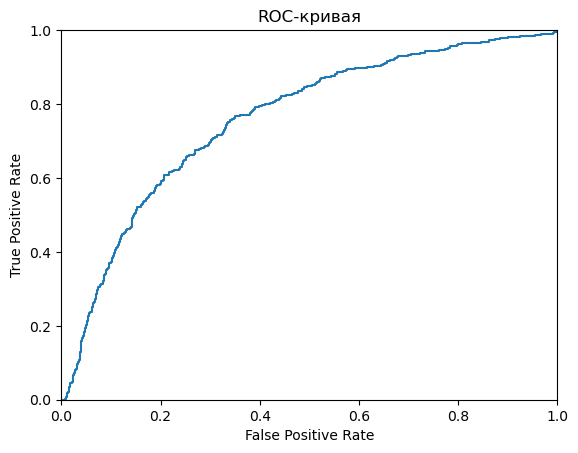

AUC-ROC равен: 0.7588266232334029


In [57]:
lr1=LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
lr1.fit(features_upsampled, target_upsampled)
predictions_valid_lr1 = lr1.predict(features_valid)
f1_lr1 = f1_score(target_valid, predictions_valid_lr1)

probabilities_valid_lr1 = lr1.predict_proba(features_valid)
probabilities_one_valid_lr1 = probabilities_valid_lr1[:, 1]
print('F1-мера равна:', f1_lr1)
fpr_lr1, tpr_lr1, thresholds_lr1 = roc_curve(target_valid, probabilities_one_valid_lr1) 


plt.figure()
plt.plot(fpr_lr1, tpr_lr1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_lr1 = roc_auc_score(target_valid, probabilities_one_valid_lr1)
print('AUC-ROC равен:', auc_roc_lr1)

Наилучший показатель F1-меры модели логистической регрессии для валидационной выборки равен 0.51. AUC-ROC при этом равен 0.78. 

Применим downsampling для работы с дисбалансом классов:

In [58]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

best_model_rf2 = None  
best_result_val_rf2 = 0
best_depth_val_rf2 = 0
for depth in range(1, 20):
    rf2 = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=depth) 
    rf2.fit(features_downsampled, target_downsampled)
    predictions_valid_rf2 = rf2.predict(features_valid)
    result_val_rf2 = f1_score(target_valid, predictions_valid_rf2)
    if result_val_rf2 > best_result_val_rf2:
        best_model_rf2 = rf2
        best_result_val_rf2 = result_val_rf2
        best_depth_val_rf2 = depth
print("Наибольшее значение F1-меры для случайного леса в валидационной выборке:", best_result_val_rf2, 'Глубина дерева:', best_depth_val_rf2)


F1-мера равна: 0.5941043083900226


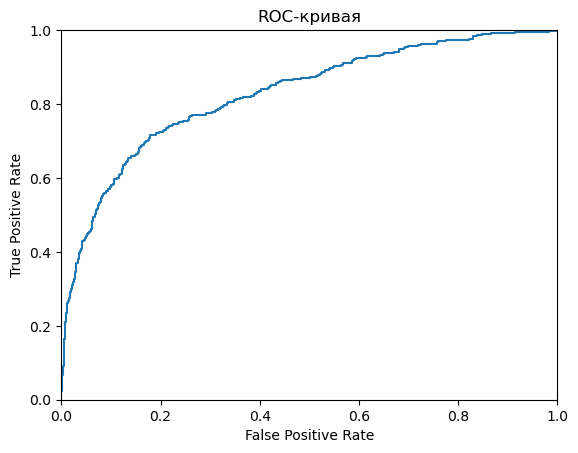

AUC-ROC равен: 0.827792353216082


In [59]:
rf2 = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=8) 
rf2.fit(features_downsampled, target_downsampled)
predictions_valid_rf2 = rf1.predict(features_valid)
f1_rf2 = f1_score(target_valid, predictions_valid_rf2)
probabilities_valid_rf2 = rf2.predict_proba(features_valid)
probabilities_one_valid_rf2 = probabilities_valid_rf2[:, 1]
print('F1-мера равна:', f1_rf2)
fpr_rf2, tpr_rf2, thresholds_rf2 = roc_curve(target_valid, probabilities_one_valid_rf2) 


plt.figure()
plt.plot(fpr_rf2, tpr_rf2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_rf2 = roc_auc_score(target_valid, probabilities_one_valid_rf2)
print('AUC-ROC равен:', auc_roc_rf2)

Наилучший показатель F1-меры модели случайного леса для валидационной выборки равен 0.6 при количестве деревьев, равном 30 и глубине деревьев, равном 8. AUC-ROC при этом равен 0.83.

best_model_dt2 = None  
best_result_val_dt2 = 0
best_depth_val_dt2 = 0
for depth in range(1, 20):
    dt2 = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    dt2.fit(features_downsampled, target_downsampled)
    predictions_valid_dt2 = dt2.predict(features_valid)
    result_val_dt2 = f1_score(target_valid, predictions_valid_dt2)
    if result_val_dt2 > best_result_val_dt2:
        best_model_dt2 = dt2
        best_result_val_dt2 = result_val_dt2
        best_depth_val_dt2 = depth
print("Наибольшее значение F1-меры для решающего дерева в валидационной выборке:", best_result_val_dt2, 'Глубина дерева:', best_depth_val_dt2)


F1-мера равна: 0.5407407407407407


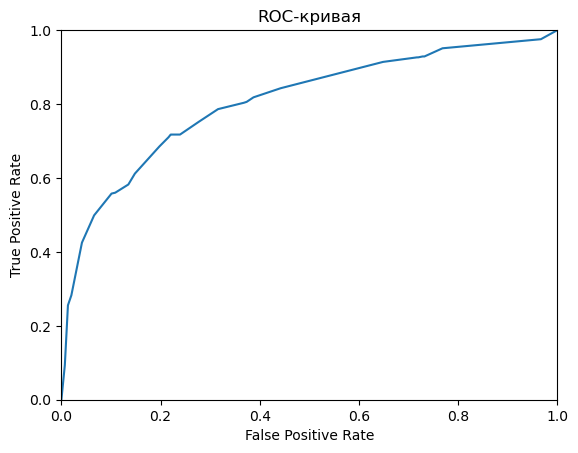

AUC-ROC равен: 0.8059800941156873


In [60]:
dt2 = DecisionTreeClassifier(random_state=12345, max_depth=6)
dt2.fit(features_downsampled, target_downsampled)
predictions_valid_dt2 = dt2.predict(features_valid)
f1_dt2 = f1_score(target_valid, predictions_valid_dt2)
probabilities_valid_dt2 = dt2.predict_proba(features_valid)
probabilities_one_valid_dt2 = probabilities_valid_dt2[:, 1]
print('F1-мера равна:', f1_dt2)
fpr_dt2, tpr_dt2, thresholds_dt2 = roc_curve(target_valid, probabilities_one_valid_dt2) 


plt.figure()
plt.plot(fpr_dt2, tpr_dt2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_dt2 = roc_auc_score(target_valid, probabilities_one_valid_dt2)
print('AUC-ROC равен:', auc_roc_dt2)

Наилучший показатель F1-меры модели дерева решений для валидационной выборки равен 0.54 при глубине деревa, равном 6. AUC-ROC при этом равен 0.8. 

F1-мера равна: 0.4917175239755885


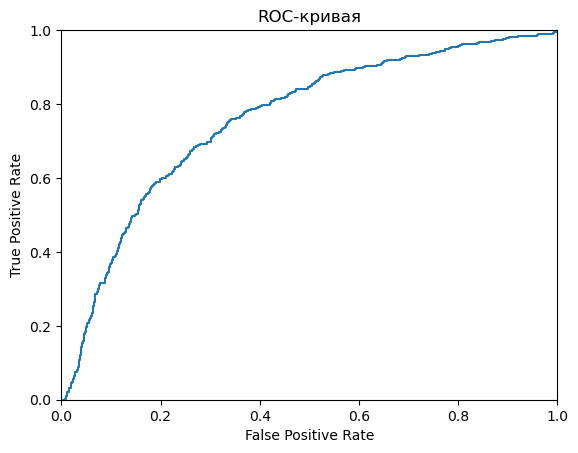

AUC-ROC равен: 0.7590965387575557


In [61]:
lr2 = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000) 
lr2.fit(features_downsampled, target_downsampled)
predictions_valid_lr2 = lr2.predict(features_valid)
f1_lr2 = f1_score(target_valid, predictions_valid_lr2)
probabilities_valid_lr2 = lr2.predict_proba(features_valid)
probabilities_one_valid_lr2 = probabilities_valid_lr2[:, 1]
print('F1-мера равна:', f1_lr2)
fpr_lr2, tpr_lr2, thresholds_lr2 = roc_curve(target_valid, probabilities_one_valid_lr2) 


plt.figure()
plt.plot(fpr_lr2, tpr_lr2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_lr2 = roc_auc_score(target_valid, probabilities_one_valid_lr2)
print('AUC-ROC равен:', auc_roc_lr2)

Наилучший показатель F1-меры модели логистической регрессии для валидационной выборки равен 0.51. AUC-ROC при этом равен 0.78. 

In [62]:
columns_name = ['imbalance_struggle', 'name_of_model', 'n_estimators', 'max_depth', 'solver', 'max_iter', 'F1', 'AUC-ROC']
info = [['Upsampling', 'RandomForestClassifier', 30, 11, 'x', 'x', 0.6, 0.83],
         ['Upsampling', 'DecisionTreeClassifier', 'x', 6, 'x', 'x', 0.56, 0.82],
['Upsampling', 'LogisticRegression', 'x', 'x', 'lbfgs', 1000, 0.51, 0.78],
['Downsampling', 'RandomForestClassifier', 30, 8, 'x', 'x', 0.6, 0.83],
['Downsampling', 'DecisionTreeClassifier', 'x', 6, 'x', 'x', 0.54, 0.8],
['Downsampling', 'LogisticRegression', 'x', 'x', 'lbfgs', 1000, 0.51, 0.78]]
df_2 = pd.DataFrame(data = info, columns = columns_name)
display(df_2)

,imbalance_struggle,name_of_model,n_estimators,max_depth,solver,max_iter,F1,AUC-ROC
0,Upsampling,RandomForestClassifier,30,11,x,x,0.60,0.83
1,Upsampling,DecisionTreeClassifier,x,6,x,x,0.56,0.82
2,Upsampling,LogisticRegression,x,x,lbfgs,1000,0.51,0.78
3,Downsampling,RandomForestClassifier,30,8,x,x,0.60,0.83
4,Downsampling,DecisionTreeClassifier,x,6,x,x,0.54,0.80
5,Downsampling,LogisticRegression,x,x,lbfgs,1000,0.51,0.78


Проверка на тестовой выборке. Уменьшение выборки у модели случайного леса показало наилучший результат F1-меры. Именно ее и применим на тестовой выборке:

F1-мера равна: 0.5603038936372269


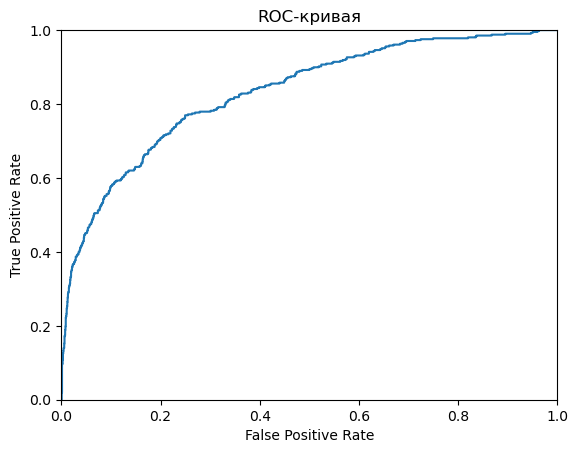

AUC-ROC равен: 0.8311363804315695


In [63]:
model = RandomForestClassifier(random_state=12345, n_estimators=30, max_depth=11)
model.fit(features_downsampled, target_downsampled)
predictions_test = model.predict(features_test)
f1=f1_score(target_test, predictions_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
print('F1-мера равна:', f1)
fpr_test, tpr_test, thresholds_test = roc_curve(target_test, probabilities_one_test) 


plt.figure()
plt.plot(fpr_test, tpr_test)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
print('AUC-ROC равен:', auc_roc_test)


## Вывод:

Итак, нами был проведен анализ данных клиентов "Бета-Банка". В столбце `Tenure` пропуски заполнли модой, а именно единицей. Выявили дисбаланс классов, почти 80% значений целевого признака равны 0. Удалили признаки, которые не понадобились при обучении моделей, преобразовали категориальные признаки техникой OHE, масштабировали количественные признаки.

Сначала построили модели случайного леса, решающего дерева и логистической регрессии без учета дисбаланса. Самый лучший результат F1 меры 0.59 показала модель случайного леса при количестве деревьев, равным 30 и глубиной деревьев 13.

Затем провели борьбу с дсбалансом. Приенили upsampling и downsampling. Метрика F1 меры у модели случайного леса при увеличении выборки выросла до 0.6. При проверке на тестовой выборке модели, которая выдала лучший результат, значение F1 меры оказалось равным 0.59.

https://github.com/Dilya1771/-supervised-learning